# Malaria Parasite Detection in Microscopic Blood Smear Images Using Deep Learning Techniques 

***We import some important library for the reading of the images***

In [1]:
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os


# we access the file where are store our images

print(os.listdir("/home/rosmael/Documents/My essay phase/Models/cell_images/"))

['Parasitized', 'Uninfected']


***The data are store into two folder with specific names of their status***

***Here we import the important libraries that will be use to build the models***

In [3]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate , Flatten , Dense , Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121 , VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import normalize
from tensorflow.keras.optimizers import Adam

***Below is the list that give us the total number of images***

In [2]:
infected_path_l = os.listdir('/home/rosmael/Documents/My essay phase/Models/cell_images/Parasitized/') 
uninfected_path_l = os.listdir('/home/rosmael/Documents/My essay phase/Models/cell_images/Uninfected/')
len(infected_path_l)+ len(infected_path_l)

27558

***Sine this number of image is big and by using the code the code was taking more than a day to run. As discused during the last meeting, for the rest we will be using half of them***

In [3]:
Image_data = []        # in this list will be append all the images read
Labels_image = []      # in this list will be append the label (statu) in the same oder of each image


# here is the path to the infected images.
# we used a for loop with a step 2 to just read half of the images.

Infected_path = "/home/rosmael/Documents/My essay phase/Models/cell_images/Parasitized/"
infected_path_l.sort()

for i in range(0, len(infected_path_l), 2):
    image_path = os.path.join(Infected_path, infected_path_l[i])
    images_pil = cv2.imread(image_path)
    image_array = Image.fromarray(images_pil , 'RGB')                     # read of image as RGB
    resize_img = image_array.resize((224 , 224))                          # resizing of image
    Image_data.append(np.array(resize_img))                               
    Labels_image.append(1)                                                # label on the image


# here we look for the total number of images read and the number of labels in our list    
len(Image_data), len(Labels_image)

(6890, 6890)

***Here we apply the same process for the second group of images***

In [4]:
uninfected_path = "/home/rosmael/Documents/My essay phase/Models/cell_images/Uninfected/"
uninfected_path_l.sort()

for j in range(0, len(uninfected_path_l), 2):
    image_pathu = os.path.join(uninfected_path, uninfected_path_l[j])
    images_pilu = cv2.imread(image_pathu)
    image_arrayu = Image.fromarray(images_pilu, 'RGB')
    resize_imgu = image_arrayu.resize((224 , 224))
    Image_data.append(np.array(resize_imgu))
    Labels_image.append(0)

# we labeled the uninfected cells as 0 

# here is the total images for the study, whych is exactly of the half of the total images
len(Image_data), len(Labels_image)

(13779, 13779)

***We transform the images and their corresponding lables as array (numbers).***

In [5]:
cells = np.array(Image_data)
labels = np.array(Labels_image)

***We look at the shape of our features (images) and the target (label)***

In [6]:
print('Shape of Cells : {} , shape of labels : {}'.format(cells.shape , labels.shape))

Shape of Cells : (13779, 224, 224, 3) , shape of labels : (13779,)


***With the following we check whether our labeled operation was well done.***

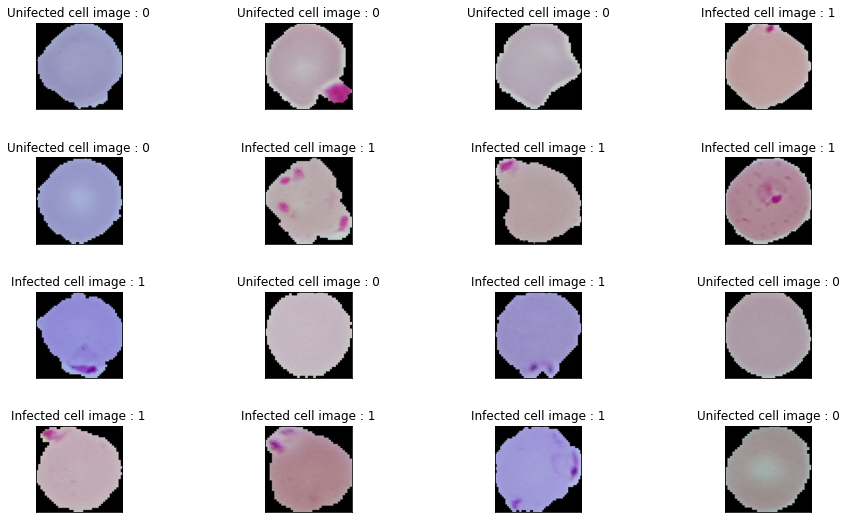

In [7]:
plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , cells.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.56, wspace = 0.56)
    plt.imshow(cells[r[0]])
    plt.title('{} : {}'.format('Infected cell image' if labels[r[0]] == 1 else 'Unifected cell image' ,
                               labels[r[0]]) )
    plt.xticks([]) , plt.yticks([])
    
plt.show()

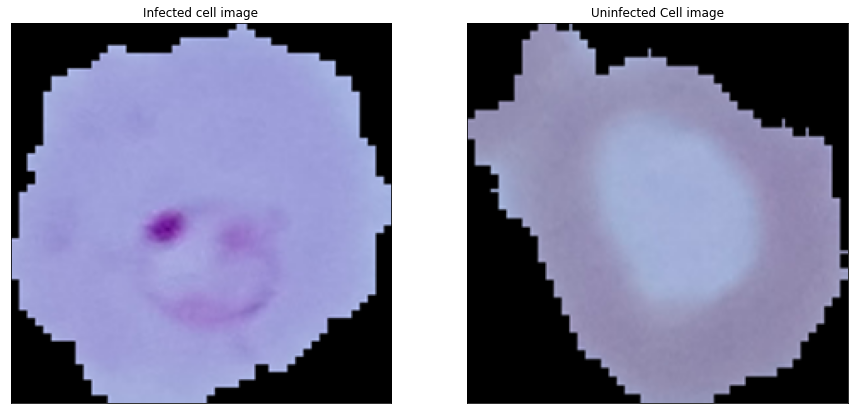

In [10]:
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
plt.imshow(cells[0])
plt.title('Infected cell image')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 2 , 2)
plt.imshow(cells[12000])
plt.title('Uninfected Cell image')
plt.xticks([]) , plt.yticks([])

plt.show()

***This aim to shuffle the all images, so that they will not be in the same other we append them in the data***

In [8]:

n = np.arange(cells.shape[0])  
np.random.shuffle(n)
cells = cells[n]
labels = labels[n]

***We convert the images as type float 32, and apply normalization on cells images***

In [9]:
cells = cells.astype(np.float32)/255.00
labels = labels.astype(np.int32) 

***We split the data into three set since are ready to use to fit our models***

In [10]:
# we split the data into train, test and validation set

from sklearn.model_selection import train_test_split

train_x , X , train_y , Y = train_test_split(cells , labels, test_size = 0.3 , random_state = 111)

test_x, valid_x, test_y, valid_y = train_test_split(X,Y, test_size = 0.5, random_state= 111)

***We print the proportion of the split data. We allocated 70% for train, 15% for validation and 15% for test***

In [11]:
print('Proportion of the data:')
print("train set: X_train: {}, Y_train: {}".format(train_x.shape, train_y.shape))
print('%===============================================%')
print('Validation set: x_validation: {}, y_validation: {}'.format(valid_x.shape, valid_y.shape))
print('%===============================================%')
print("test shape: x_test: {}, y_test: {}".format(test_x.shape, test_y.shape))

Proportion of the data:
train set: X_train: (9645, 224, 224, 3), Y_train: (9645,)
%===============================================%
Validation set: x_validation: (2067, 224, 224, 3), y_validation: (2067,)
%===============================================%
test shape: x_test: (2067, 224, 224, 3), y_test: (2067,)


***We plot below the repatirtion of the images in each set***

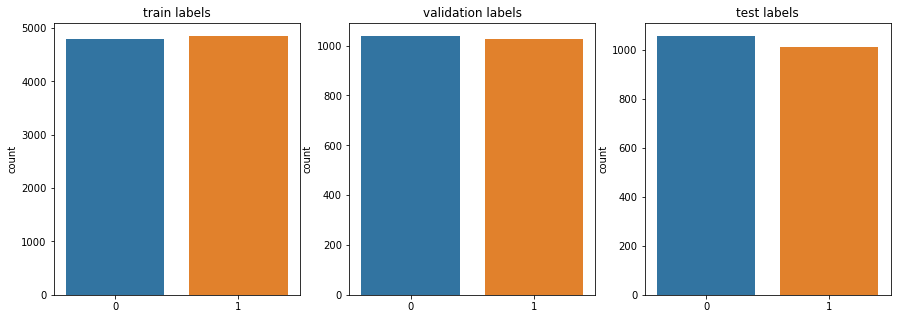

In [12]:
plt.figure(1 , figsize = (15 ,5))
n = 0 
for z , j in zip([train_y , valid_y,  test_y] , ['train labels','validation labels', 'test labels']):
    n += 1
    plt.subplot(1 , 3  , n)
    sns.countplot(x = z )
    plt.title(j)
plt.show()

***Here are important libraries for cheking the best parameters of the model: keras tuner***

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

In [ ]:
# def myvgg16_model(input_shape):
#     model = VGG16(include_top=False, input_shape= input_shape)  #  we import vgg16 with input size = (50, 50, 3)
#     # make the wieght not trainable
#     for layer in model.layers:
#         layer.trainable = False

    
#     # # add new classifier layers
#     flat1 = Flatten()(model.layers[-1].output)
#     class1 = Dense(100, activation='relu')(flat1)
#     output = Dense(1, activation='sigmoid')(class1)

#     # # define new model
#     model = Model(inputs=model.inputs, outputs=output)
#     # # summarize
#     return model


In [ ]:
# Do not run this cell

In [19]:
def build_my_vgg(hp):
    modelvgg = VGG16(include_top=False, weights='imagenet', input_shape = (224, 224, 3))
    for layer in modelvgg.layers:
        layer.trainable = False
    
    # add new classifier
    flat1 = Flatten()(modelvgg.layers[-1].output)
    class1 = Dense(units=hp.Int('dense_1_units_vgg', min_value=32, max_value=128, step=16), activation='relu')(flat1)
    output = Dense(1, activation = 'sigmoid')(class1)
    
    new_modelvgg16 = Model(inputs = modelvgg.inputs, outputs = output)
    
    
    # Compile the model
    new_modelvgg16.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])),
                       loss='binary_crossentropy', metrics=['accuracy'])
    return new_modelvgg16




tuner_search = RandomSearch(build_my_vgg, objective='val_accuracy', max_trials=5, 
                            directory='output_cluster', project_name='newPre_trained_VGG16_Malaria')
tuner_search.search(train_x, train_y, epochs=2, validation_data = (valid_x, valid_y))




# get the best model
new_modelvgg16 = tuner_search.get_best_models(num_models=1)[0]
best_param_vgg16 = tuner_search.get_best_hyperparameters(num_trials=1)[0]





# # print the best parameter to screen


Trial 5 Complete [01h 47m 27s]
val_accuracy: 0.9264634847640991

Best val_accuracy So Far: 0.9264634847640991
Total elapsed time: 13h 23m 39s
INFO:tensorflow:Oracle triggered exit


In [20]:
param_vgg16 = ""
for pair in best_param_vgg16.values:
    print("{}: {}".format(pair, best_param_vgg16[pair]))
    param_vgg16 += "{}:{}; ".format(pair, best_param_vgg16[pair]) 
    

dense_1_units_vgg: 80
learning_rate: 0.001


In [21]:
Hvgg = new_modelvgg16.fit(train_x, train_y, epochs=15, validation_data = (valid_x, valid_y), 
                          initial_epoch=2, batch_size=64)

Epoch 3/15
151/151 [==============================] - 3210s 21s/step - loss: 0.1817 - accuracy: 0.9316 - val_loss: 0.2170 - val_accuracy: 0.9144
Epoch 4/15
151/151 [==============================] - 3219s 21s/step - loss: 0.1647 - accuracy: 0.9398 - val_loss: 0.2109 - val_accuracy: 0.9323
Epoch 5/15
151/151 [==============================] - 3215s 21s/step - loss: 0.1568 - accuracy: 0.9427 - val_loss: 0.2498 - val_accuracy: 0.9221
Epoch 6/15
151/151 [==============================] - 3203s 21s/step - loss: 0.1384 - accuracy: 0.9501 - val_loss: 0.2291 - val_accuracy: 0.9090
Epoch 7/15
151/151 [==============================] - 3209s 21s/step - loss: 0.1387 - accuracy: 0.9486 - val_loss: 0.2040 - val_accuracy: 0.9269
Epoch 8/15
151/151 [==============================] - 3210s 21s/step - loss: 0.1267 - accuracy: 0.9561 - val_loss: 0.3170 - val_accuracy: 0.8858
Epoch 9/15
151/151 [==============================] - 3189s 21s/step - loss: 0.1133 - accuracy: 0.9606 - val_loss: 0.2029 - val_ac

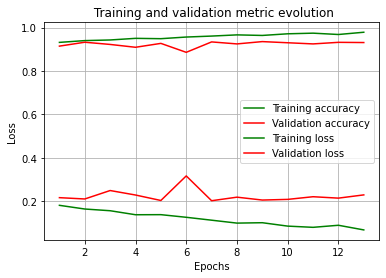

In [28]:
loss = Hvgg.history['loss']
val_loss = Hvgg.history['val_loss']
epochs = range(1, len(loss)+1)
acc = Hvgg.history['accuracy']
val_acc = Hvgg.history['val_accuracy']
plt.plot(epochs, acc, 'g', label = 'Training accuracy')
plt.plot(epochs, val_acc,'r', label = "Validation accuracy")
plt.plot(epochs, loss, 'g', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = "Validation loss")
plt.title(" Training and validation metric evolution")
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [29]:
new_modelvgg16.save('last_vgg_model.h5')

In [ ]:
vgg16m = load_model("last_vgg_model.h5")
#vgg16m.summary()

# The pre-trained VGG model

***Note that this model is not defined the way with the next one because I directly the parameters I got from it when I run before with the all data. In case need I thinking about run thin model on 15 epochs as the two next ones***

In [23]:
def myvgg16_model(input_shape):
    model = VGG16(include_top=False, input_shape= input_shape)  #  we import vgg16 with input size = (50, 50, 3)
     # make the wieght not trainable
    for layer in model.layers:
        layer.trainable = False

    # # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(32, activation='relu')(flat1)
    output = Dense(1, activation='sigmoid')(class1)

     # # define new model
    model = Model(inputs=model.inputs, outputs=output)
     # # summarize
        #  0.0001
    Optimizer2 = Adam( learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, weight_decay=None,
                  clipnorm=None, clipvalue=None, global_clipnorm=None, use_ema=False, ema_momentum=0.99,
                  ema_overwrite_frequency=None, jit_compile=True, name="Adam")
    model.compile(optimizer= Optimizer2, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# Fit of the first VGG model

In [27]:
input_shape = (224, 224, 3)

modelvgg16 = myvgg16_model(input_shape)

Histo_vgg = modelvgg16.fit(train_x, train_y, epochs=10, validation_data = (valid_x, valid_y), batch_size=64)

Epoch 1/10
151/151 [==============================] - 3311s 22s/step - loss: 0.4675 - accuracy: 0.7897 - val_loss: 0.3783 - val_accuracy: 0.8278
Epoch 2/10
151/151 [==============================] - 3268s 22s/step - loss: 0.3299 - accuracy: 0.8723 - val_loss: 0.2999 - val_accuracy: 0.8873
Epoch 3/10
151/151 [==============================] - 3237s 21s/step - loss: 0.2721 - accuracy: 0.9036 - val_loss: 0.2652 - val_accuracy: 0.9008
Epoch 4/10
151/151 [==============================] - 3227s 21s/step - loss: 0.2399 - accuracy: 0.9161 - val_loss: 0.2613 - val_accuracy: 0.8907
Epoch 5/10
151/151 [==============================] - 3268s 22s/step - loss: 0.2251 - accuracy: 0.9191 - val_loss: 0.2304 - val_accuracy: 0.9139
Epoch 6/10
151/151 [==============================] - 3257s 22s/step - loss: 0.2025 - accuracy: 0.9311 - val_loss: 0.2190 - val_accuracy: 0.9226
Epoch 7/10
151/151 [==============================] - 3248s 22s/step - loss: 0.1915 - accuracy: 0.9349 - val_loss: 0.2113 - val_ac

In [1]:
#modelvgg16.summary()

# Evalution of the pre-trained model on the test data

In [30]:
modelvgg16.save("malaria_predict_with_vgg16_50.h5")

1/1 [==============================] - 1s 1s/step
The prediction for this image is:  [[0.9991116]]
The actual label for this image is:  1


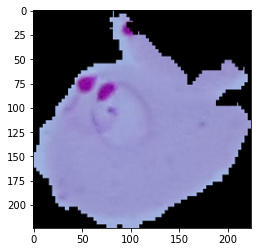

In [31]:
n = 16 # select idex image to be load for the testing

# test_y    test_x
img = test_x[n]
plt.imshow(img)


input_img = np.expand_dims(img, axis = 0)
print("The prediction for this image is: ", modelvgg16.predict(input_img))
print("The actual label for this image is: ",test_y[n]) 

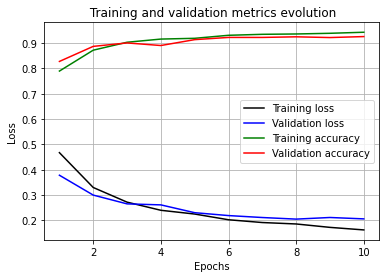

In [86]:
loss = Histo_vgg.history['loss']
val_loss = Histo_vgg.history['val_loss']
acc = Histo_vgg.history['accuracy']
val_acc = Histo_vgg.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'k', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = "Validation loss")
plt.plot(epochs, acc, 'g', label = 'Training accuracy')
plt.plot(epochs, val_acc,'r', label = "Validation accuracy")
plt.title(" Training and validation metrics evolution")
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# acc = Histo_vgg.history['accuracy']
# val_acc = Histo_vgg.history['val_accuracy']
# plt.plot(epochs, acc, 'g', label = 'Training accuracy')
# plt.plot(epochs, val_acc,'r', label = "Validation accuracy")
# plt.title("Training and validation accuracy")
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [ ]:
# save the first model: pre-trained vgg 16

In [ ]:
#modelvgg16.save("malaria_predict_with_vgg16.h5")

In [40]:
from tensorflow.keras.models import save_model

save_model(modelvgg16, 'malaria_vgg16_model.h5')

In [43]:
#======================================================================================================#
#                                        DenseNet pre-trained                                          #
#======================================================================================================#

In [44]:
def build_densenet(hp):
    model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for i in range(len(model.layers)):
        model.layers[i].trainable = False
        
    x = MaxPool2D(pool_size=hp.Choice('Max_pool_fm1', values = [3,5]))(model.output)
    x = Flatten()(x)
    x = Dense(units=hp.Int('dense_2_units', min_value=64, max_value=128, step=16), activation='relu')(x)  
    x = Dropout(hp.Float('dropout', min_value=0.15, max_value=0.5, step=0.1))(x)
    output = Dense(1, activation='sigmoid', name='predictions')(x)
    model_densenet = Model(inputs = model.input, outputs=output)
    
    
    model_densenet.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])),
              loss='mean_squared_error', metrics=['accuracy'])
    
    # remove this loos and substitute by 'binary_crossentropy'
    
    return model_densenet

In [45]:
tuner_search = RandomSearch(build_densenet, objective='val_accuracy', max_trials=5, 
                            directory='output_cluster', project_name='model_name_Malaria_densenet')
tuner_search.search(train_x, train_y, epochs=2, validation_split=0.2)


Trial 5 Complete [00h 30m 33s]
val_accuracy: 0.9097978472709656

Best val_accuracy So Far: 0.9331259727478027
Total elapsed time: 02h 42m 28s
INFO:tensorflow:Oracle triggered exit


In [46]:
# get the best model
model = tuner_search.get_best_models(num_models=1)[0]
best_param = tuner_search.get_best_hyperparameters(num_trials=1)[0]

In [47]:
# print the best parameter to screen
param = ""
for pair in best_param.values:
    print("{}: {}".format(pair, best_param[pair]))
    param += "{}:{}; ".format(pair, best_param[pair]) 

Max_pool_fm1: 3
dense_2_units: 112
dropout: 0.25
learning_rate: 0.0001


In [48]:
H = model.fit(train_x, train_y, epochs=15, validation_data = (valid_x, valid_y), initial_epoch=2, batch_size=64)

Epoch 3/15
151/151 [==============================] - 1194s 8s/step - loss: 0.0520 - accuracy: 0.9334 - val_loss: 0.0530 - val_accuracy: 0.9328
Epoch 4/15
151/151 [==============================] - 1157s 8s/step - loss: 0.0483 - accuracy: 0.9393 - val_loss: 0.0556 - val_accuracy: 0.9284
Epoch 5/15
151/151 [==============================] - 1157s 8s/step - loss: 0.0445 - accuracy: 0.9431 - val_loss: 0.0483 - val_accuracy: 0.9381
Epoch 6/15
151/151 [==============================] - 1154s 8s/step - loss: 0.0428 - accuracy: 0.9471 - val_loss: 0.0470 - val_accuracy: 0.9405
Epoch 7/15
151/151 [==============================] - 1160s 8s/step - loss: 0.0405 - accuracy: 0.9496 - val_loss: 0.0459 - val_accuracy: 0.9415
Epoch 8/15
151/151 [==============================] - 1152s 8s/step - loss: 0.0382 - accuracy: 0.9525 - val_loss: 0.0492 - val_accuracy: 0.9361
Epoch 9/15
151/151 [==============================] - 1153s 8s/step - loss: 0.0365 - accuracy: 0.9540 - val_loss: 0.0438 - val_accuracy:

In [49]:
# Save the best hyperparameters to a Pandas dataframe


best_params = pd.DataFrame({
    'Max_pool_fm1' : best_param.get('Max_pool_fm1'),
    'dense_2_units': best_param.get('dense_2_units'),
    'learning_rate': best_param.get('learning_rate')
}, index=[0])
print(best_params )

   Max_pool_fm1  dense_2_units  learning_rate
0             3            112         0.0001


1/1 [==============================] - 3s 3s/step
The prediction for this image is:  [[0.9999974]]
The actual label for this image is:  1


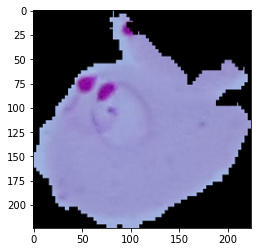

In [51]:
n = 16 # select idex image to be load for the testing

# test_y    test_x
img = test_x[n]
plt.imshow(img)


input_img = np.expand_dims(img, axis = 0)
print("The prediction for this image is: ", model.predict(input_img))
print("The actual label for this image is: ",test_y[n]) 

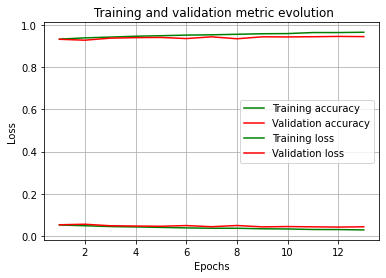

In [59]:
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(loss)+1)
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
plt.plot(epochs, acc, 'g', label = 'Training accuracy')
plt.plot(epochs, val_acc,'r', label = "Validation accuracy")
plt.plot(epochs, loss, 'g', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = "Validation loss")
plt.title(" Training and validation metric evolution")
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [60]:
model.save("malaria_predict_with_densenet121.h5")

In [ ]:
#============================================================================================================#
#                                             Proposed CNN model                                             #
#============================================================================================================#

In [69]:
def define_optimised_model(hp):
    """ This function if using keras methode to propose us a model"""
    model_p =  keras.Sequential([
        keras.layers.Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=64, step=16), 
                                                   kernel_size = hp.Choice('conv_1_kernel', values = [3,5]),activation = 'relu',
                                                   input_shape = (224, 224, 3)),
                               
        keras.layers.MaxPooling2D(pool_size = hp.Choice('pool_fm1', values = [3,5])),
                               
        keras.layers.Conv2D(filters = hp.Int('conv_2_filter', min_value = 64, max_value = 128, step = 32), 
                                                  kernel_size = hp.Choice('conv_2_kernel', values = [3,5]), activation = 'relu'),
          # new conv                     
        keras.layers.Conv2D(filters = hp.Int('conv_22_filter', min_value = 64, max_value = 128, step = 32), 
                                                  kernel_size = hp.Choice('conv_22_kernel', values = [3,5]), activation = 'relu'),
           # look to remove the layer between                    
        keras.layers.MaxPooling2D(pool_size = hp.Choice('pool_fm2', values = [3,5])),
                               
        #keras.layers.Conv2D(filters = hp.Int('conv_3_filter', min_value = 128, max_value = 256, step = 64), 
       #                                           kernel_size = hp.Choice('conv_3_kernel', values = [3,5]), activation = 'relu'),
                               
        #keras.layers.MaxPooling2D(pool_size = hp.Choice('pool_fm3', values = [3,5])),
        # add it here
        keras.layers.Conv2D(filters = hp.Int('conv_4_filter', min_value = 256, max_value = 512, step = 16),
                                                  kernel_size = hp.Choice('conv_4_kernel', values = [3,5]), activation = 'relu'),
        keras.layers.Conv2D(filters = hp.Int('conv_44_filter', min_value = 256, max_value = 512, step = 16),
                                                  kernel_size = hp.Choice('conv_44_kernel', values = [3,5]), activation = 'relu'),
                                                      
        keras.layers.MaxPooling2D(pool_size = hp.Choice('pool_fm4', values = [3,5])),
                               
        keras.layers.Flatten(),
                               
        keras.layers.Dense(units=hp.Int('dense_a_units', min_value=64, max_value=128, step=16), activation='relu'),
        keras.layers.Dropout(hp.Float('dropout', min_value=0.15, max_value=0.5, step=0.1)),                    
        keras.layers.Dense(1, activation='sigmoid')])
    
                               
    model_p.compile(optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])),
                  loss='mean_squared_error', metrics=['accuracy'])
    
    return model_p

In [70]:

print("[INFO] training the network...")
tuner_search = RandomSearch(define_optimised_model, objective='val_accuracy', max_trials=5, directory='output_cluster',project_name='proposed_model_for_malaria_detection')
tuner_search.search(train_x, train_y, epochs=2, validation_split=0.2)
    

Trial 5 Complete [00h 13m 26s]
val_accuracy: 0.9393467903137207

Best val_accuracy So Far: 0.9393467903137207
Total elapsed time: 01h 58m 18s
INFO:tensorflow:Oracle triggered exit


In [71]:
# get the best model
model_p = tuner_search.get_best_models(num_models=1)[0]
best_param = tuner_search.get_best_hyperparameters(num_trials=1)[0]

In [72]:
# print the best parameter to screen
paramm = ""
for pair in best_param.values:
    print("{}: {}".format(pair, best_param[pair]))
    param += "{}:{}; ".format(pair, best_param[pair]) 

conv_1_filter: 32
conv_1_kernel: 3
pool_fm1: 5
conv_2_filter: 64
conv_2_kernel: 5
conv_22_filter: 96
conv_22_kernel: 5
pool_fm2: 3
conv_4_filter: 464
conv_4_kernel: 5
conv_44_filter: 384
conv_44_kernel: 3
pool_fm4: 5
dense_a_units: 64
dropout: 0.15
learning_rate: 0.001


In [74]:
Hist = model_p.fit(train_x, train_y, epochs=15, validation_data = (valid_x, valid_y), initial_epoch=2, batch_size=64)

Epoch 3/15
151/151 [==============================] - 513s 3s/step - loss: 0.0487 - accuracy: 0.9443 - val_loss: 0.0473 - val_accuracy: 0.9458
Epoch 4/15
151/151 [==============================] - 461s 3s/step - loss: 0.0466 - accuracy: 0.9469 - val_loss: 0.0407 - val_accuracy: 0.9516
Epoch 5/15
151/151 [==============================] - 451s 3s/step - loss: 0.0410 - accuracy: 0.9520 - val_loss: 0.0381 - val_accuracy: 0.9545
Epoch 6/15
151/151 [==============================] - 454s 3s/step - loss: 0.0388 - accuracy: 0.9547 - val_loss: 0.0376 - val_accuracy: 0.9531
Epoch 7/15
151/151 [==============================] - 450s 3s/step - loss: 0.0384 - accuracy: 0.9542 - val_loss: 0.0403 - val_accuracy: 0.9526
Epoch 8/15
151/151 [==============================] - 449s 3s/step - loss: 0.0366 - accuracy: 0.9567 - val_loss: 0.0426 - val_accuracy: 0.9502
Epoch 9/15
151/151 [==============================] - 450s 3s/step - loss: 0.0371 - accuracy: 0.9567 - val_loss: 0.0400 - val_accuracy: 0.9560

In [ ]:
model_p.summary()

In [75]:
_, acc = model_p.evaluate(test_x, test_y)  # test on the unseen data
print("Accuracy = ", (acc*100.0), "%")

65/65 [==============================] - 26s 385ms/step - loss: 0.0300 - accuracy: 0.9627
Accuracy =  96.27479314804077 %


1/1 [==============================] - 0s 298ms/step
The prediction for this image is:  [[1.]]
The actual label for this image is:  1


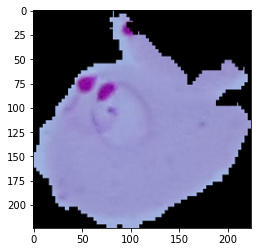

In [76]:
n = 16 # select idex image to be load for the testing

# test_y    test_x
img = test_x[n]
plt.imshow(img)


input_img = np.expand_dims(img, axis = 0)
print("The prediction for this image is: ", model_p.predict(input_img))
print("The actual label for this image is: ",test_y[n]) 

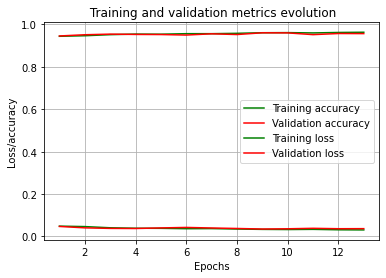

In [83]:
loss = Hist.history['loss']
val_loss = Hist.history['val_loss']
epochs = range(1, len(loss)+1)
acc = Hist.history['accuracy']
val_acc = Hist.history['val_accuracy']
plt.plot(epochs, acc, 'g', label = 'Training accuracy')
plt.plot(epochs, val_acc,'r', label = "Validation accuracy")
plt.plot(epochs, loss, 'g', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = "Validation loss")
plt.title(" Training and validation metrics evolution")
plt.xlabel("Epochs")
plt.ylabel('Loss/accuracy')
plt.grid()
plt.legend()
plt.show()

In [ ]:
model_p.save("malaria_predict_proposed_model.h5")

In [ ]:
from tensorflow.keras.models import load_model
model_p = load_model("malaria_predict_proposed_model.h5")
#model_p.summary()

***Basicaly the best model is quite the last one: my proposed model, after come Pre-trained DenseNet121, and the last is Pre-trained VGG16 but I believe that it will perform again whan I will run will 15 epochs too.***

***I'm waiting for your comment and sugestion if the can improve, for me to start write on the model***

# Compare the models

In [24]:
# np.save("test_x",test_x)
# np.save('test_y', test_y)

In [3]:
# Load of the test data
import numpy as np

Test_x = np.load("test_x.npy")
Test_y = np.load("test_y.npy")

In [4]:
print("Test x shape: {}".format(Test_x.shape))
print("Test Y shape: {}".format(Test_y.shape))

Test x shape: (2067, 224, 224, 3)
Test Y shape: (2067,)


In [1]:
from tensorflow.keras.models import load_model

In [5]:
# lord of the models



modelvgg16       = load_model('last_vgg_model.h5')
modelDenseNet121 = load_model("malaria_predict_with_densenet121.h5")
model_proposed   = load_model("malaria_predict_proposed_model.h5")

In [6]:
# prediction with VGG


# predict probabilities for test set
ypred_vgg = modelvgg16.predict(Test_x, verbose=1)
# predict crisp classes for test set
yhat_classeV = modelvgg16.predict(Test_x, verbose=1)
# reduce to 1d array
yhat_probV = ypred_vgg[:, 0]
yhat_classesV = yhat_classeV[:, 0]


65/65 [==============================] - 585s 9s/step


65/65 [==============================] - 580s 9s/step


In [10]:
# Prediction with a densenet121



# predict probabilities for test set
yhat_probDense = modelDenseNet121.predict(Test_x, verbose=1)
# predict crisp classes for test set
yhat_classesD = modelDenseNet121.predict(Test_x, verbose=1)
# reduce to 1d array
yhat_probDe = yhat_probDense[:, 0]
yhat_classesDe = yhat_classesD[:, 0]

65/65 [==============================] - 180s 3s/step


In [14]:
# Prediction with the CNN


# predict probabilities for test set
yhat_probpro = model_proposed.predict(Test_x, verbose=1)
# predict crisp classes for test set
yhat_classespro = model_proposed.predict(Test_x, verbose=1)
# reduce to 1d array
yhat_probpro = yhat_probpro[:, 0]
yhat_classespr = yhat_classespro[:, 0]

65/65 [==============================] - 27s 419ms/step


In [8]:
# the different y and y_hat before the cure
#=======================================================================================================================
# Vgg: y_pred = yhat_classesV.round() # Densenet: y_pred = yhat_classesDe.round() # CNN: y_pred = yhat_classespr.round()
#


y_true = Test_y
y_pred = yhat_classesV.round()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras

# Load the three models from disk
model1 = keras.models.load_model('last_vgg_model.h5')
model2 = keras.models.load_model('malaria_predict_with_densenet121.h5')
model3 = keras.models.load_model('malaria_predict_proposed_model.h5')

# Load the test data
x_test, y_test =   Test_x, Test_y               #    load_test_data()  # replace with your own function to load test data

# Make predictions on the test data using each model
y_pred1 = model1.predict(x_test)
y_pred2 = model2.predict(x_test)
y_pred3 = model3.predict(x_test)

# Compute the ROC curves and AUC scores for each model
fpr1, tpr1, _ = roc_curve(y_test, y_pred1)
fpr2, tpr2, _ = roc_curve(y_test, y_pred2)
fpr3, tpr3, _ = roc_curve(y_test, y_pred3)
roc_auc1 = roc_auc_score(y_test, y_pred1)
roc_auc2 = roc_auc_score(y_test, y_pred2)
roc_auc3 = roc_auc_score(y_test, y_pred3)

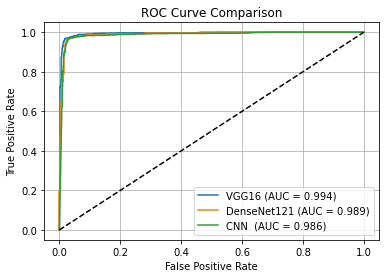

In [126]:
# Plot the ROC curves
#plt.figure(figsize=(9,5)) 
plt.plot(fpr1, tpr1, label='VGG16 (AUC = {:.3f})'.format(roc_auc1))
plt.plot(fpr2, tpr2, label='DenseNet121 (AUC = {:.3f})'.format(roc_auc2))
plt.plot(fpr3, tpr3, label='CNN  (AUC = {:.3f})'.format(roc_auc3))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')


# f = plt.figure()
# f.set_figwidth(10)
# f.set_figheight(10)

plt.legend()
plt.grid()
plt.show()


In [42]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools   

In [39]:
cmatrix1 = confusion_matrix(Test_y, y_pred1.round())
cmatrix2 = confusion_matrix(Test_y, y_pred2.round())
cmatrix3 = confusion_matrix(Test_y, y_pred3.round())

print("Confusion matrix model1")
print('-----------------------------------------------------------')
print(cmatrix1)
print("Confusion matrix model2")
print('-----------------------------------------------------------')
print(cmatrix2)
print("Confusion matrix model3")
print('-----------------------------------------------------------')
print(cmatrix3)

Confusion matrix model1
-----------------------------------------------------------
[[1017   40]
 [  23  987]]
Confusion matrix model2
-----------------------------------------------------------
[[1023   34]
 [  33  977]]
Confusion matrix model3
-----------------------------------------------------------
[[1028   29]
 [  40  970]]


In [43]:
def plot_cmatrix(cm):
   # cm = cmatrix1
# Plot the confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Oranges)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Uninfected', 'Infected'])
    plt.yticks(tick_marks, ['Uninfected', 'Infected'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

    # add values to the cells of the confusion matrix
    width, height = cm.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                         horizontalalignment='center',
                         verticalalignment='center')

    plt.show()

----------------------------------------------
Confusion matrix from model 1
----------------------------------------------


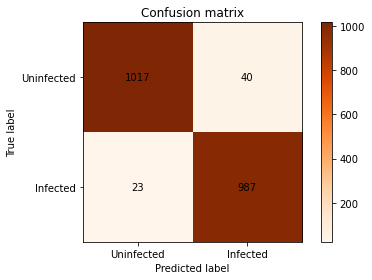

In [79]:
# plot the confusion matrix
print('----------------------------------------------')
print('Confusion matrix from model 1')
print('----------------------------------------------')
plot_cmatrix(cm=cmatrix1)

plt.show()

----------------------------------------------
Confusion matrix from model 2
----------------------------------------------


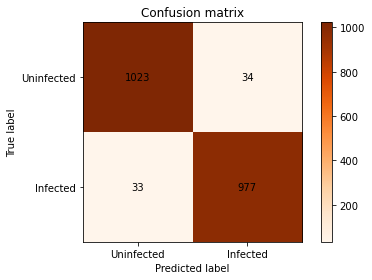

In [80]:
# plot the confusion matrix
print('----------------------------------------------')
print('Confusion matrix from model DenseNet121')
print('----------------------------------------------')
plot_cmatrix(cm=cmatrix2)

plt.show()

----------------------------------------------
Confusion matrix from model 3
----------------------------------------------


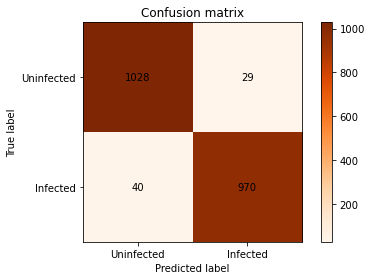

In [81]:
# plot the confusion matrix
print('----------------------------------------------')
print('Confusion matrix from model 3')
print('----------------------------------------------')
plot_cmatrix(cm=cmatrix3)

plt.show()

In [82]:
#classification report 
class_rep1 = classification_report(Test_y, y_pred1.round())
class_rep2 = classification_report(Test_y, y_pred2.round())
class_rep3 = classification_report(Test_y, y_pred3.round())

In [97]:
_, acc = model1.evaluate(Test_x, Test_y)  # test on the unseen data
print("Accuracy = ", (acc*100.0), "%")

65/65 [==============================] - 591s 9s/step - loss: 0.1018 - accuracy: 0.9695
Accuracy =  96.95210456848145 %


In [83]:
print('---------------------------------------------------------')
print("Classification report of model VGG16")
print("---------------------------------------------------------")
print(class_rep1)

---------------------------------------------------------
Classification report of model VGG16
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1057
           1       0.96      0.98      0.97      1010

    accuracy                           0.97      2067
   macro avg       0.97      0.97      0.97      2067
weighted avg       0.97      0.97      0.97      2067



In [98]:
_, acc = model2.evaluate(Test_x, Test_y)  # test on the unseen data
print("Accuracy = ", (acc*100.0), "%")

65/65 [==============================] - 185s 3s/step - loss: 0.0294 - accuracy: 0.9676
Accuracy =  96.75858616828918 %


In [84]:
print('---------------------------------------------------------')
print("Classification report of model DenseNet121")
print("---------------------------------------------------------")
print(class_rep2)

---------------------------------------------------------
Classification report of model DenseNet121
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1057
           1       0.97      0.97      0.97      1010

    accuracy                           0.97      2067
   macro avg       0.97      0.97      0.97      2067
weighted avg       0.97      0.97      0.97      2067



In [100]:
_, acc = model3.evaluate(Test_x, Test_y)  # test on the unseen data
print("Accuracy = ", (acc*100.0), "%")

65/65 [==============================] - 25s 383ms/step - loss: 0.0294 - accuracy: 0.9666
Accuracy =  96.6618299484253 %


In [85]:
print('---------------------------------------------------------')
print("Classification report of model CNN")
print("---------------------------------------------------------")
print(class_rep3)

---------------------------------------------------------
Classification report of model CNN
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1057
           1       0.97      0.96      0.97      1010

    accuracy                           0.97      2067
   macro avg       0.97      0.97      0.97      2067
weighted avg       0.97      0.97      0.97      2067



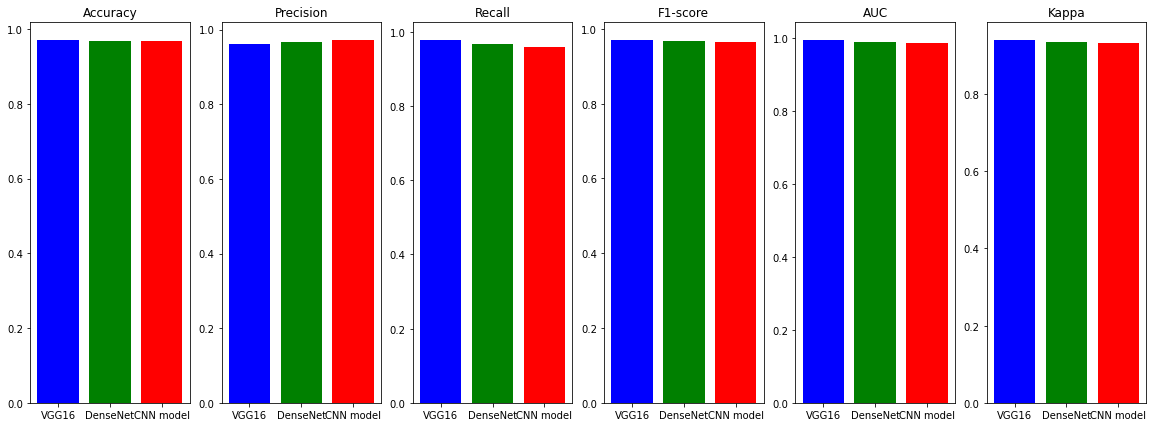

In [130]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score, precision_score
import tensorflow as tf

# # Load the test data
test_data = Test_x
test_labels = Test_y

# # Make predictions on the test data using each model
pred1 = y_pred1
pred2 = y_pred2
pred3 = y_pred3

# Calculate evaluation metrics for each model
acc1 = accuracy_score(test_labels, np.round(pred1))
preci1 = precision_score(test_labels, np.round(pred1))
recall1 = recall_score(test_labels, np.round(pred1))
f1_score1 = f1_score(test_labels, np.round(pred1))
auc1 = roc_auc_score(test_labels, pred1)
kappa1 = cohen_kappa_score(test_labels, np.round(pred1))

acc2 = accuracy_score(test_labels, np.round(pred2))
preci2 = precision_score(test_labels, np.round(pred2))
recall2 = recall_score(test_labels, np.round(pred2))
f1_score2 = f1_score(test_labels, np.round(pred2))
auc2 = roc_auc_score(test_labels, pred2)
kappa2 = cohen_kappa_score(test_labels, np.round(pred2))

acc3 = accuracy_score(test_labels, np.round(pred3))
preci3 = precision_score(test_labels, np.round(pred3))
recall3 = recall_score(test_labels, np.round(pred3))
f1_score3 = f1_score(test_labels, np.round(pred3))
auc3 = roc_auc_score(test_labels, pred3)
kappa3 = cohen_kappa_score(test_labels, np.round(pred3))

# Plot the evaluation metrics for each model
labels = ['VGG16', 'DenseNet', 'CNN model']
acc = [acc1, acc2, acc3]
preci = [preci1, preci2, preci3]
recall = [recall1, recall2, recall3]
f1 = [f1_score1, f1_score2, f1_score3]
auc = [auc1, auc2, auc3]
kappa = [kappa1, kappa2, kappa3]

#---------------------------------------------------------------
colors=['blue','green', 'red']
from matplotlib.colors import Normalize
import matplotlib.cm as cm
# Get a color map
my_cmap = cm.get_cmap('jet')
my_norm = Normalize(vmin=0, vmax=8)

fig, ax = plt.subplots(1, 6, figsize=(20, 7))
ax[0].bar(labels, acc, color=colors)
ax[0].set_title('Accuracy')
ax[1].bar(labels, preci, color = colors)
ax[1].set_title("Precision")
ax[2].bar(labels, recall, color=colors)
ax[2].set_title('Recall')
ax[3].bar(labels, f1, color=colors)
ax[3].set_title('F1-score')
ax[4].bar(labels, auc, color=colors)
ax[4].set_title('AUC')
ax[5].bar(labels, kappa, color=colors)
ax[5].set_title('Kappa')
plt.show()

In [136]:
acc1,preci1, recall1 ,f1_score1 ,auc1 ,kappa1 

print('Accuracy of model vgg')
print('------------------------------------------------------------------------------------------------------------')
print('Accuracy: {},\nPrecision: {}, \nRecall: {},\nF1-Score: {}, \nAUC: {},\nKappa: {}'.format(acc1,preci1, recall1 ,f1_score1 ,auc1 ,kappa1 ))

Accuracy of model vgg
------------------------------------------------------------------------------------------------------------
Accuracy: 0.969521044992743,
Precision: 0.9610516066212269, 
Recall: 0.9772277227722772,
F1-Score: 0.9690721649484536, 
AUC: 0.9939704188015773,
Kappa: 0.9390333712713705


In [138]:
acc2,preci2, recall2 ,f1_score2 ,auc2,kappa2

print('Accuracy of model DenseNet121')
print('------------------------------------------------------------------------------------------------------------')

print('Accuracy: {},\nPrecision: {}, \nRecall: {}, \nF1-Score: {}, \nAUC: {}, \nKappa: {}'.format(acc2,preci2, recall2 ,f1_score2 ,auc2,kappa2))

Accuracy of model DenseNet121
------------------------------------------------------------------------------------------------------------
Accuracy: 0.9675858732462506,
Precision: 0.9663699307616221, 
Recall: 0.9673267326732673, 
F1-Score: 0.9668480950024739, 
AUC: 0.9890948602901918, 
Kappa: 0.9351396388232038


In [140]:
acc3, recall3 ,f1_score3 ,auc2,kappa3

print('Accuracy of CNN model.')
print('------------------------------------------------------------------------------------------------------------')

print('Accuracy: {},\nPrecision: {}, \nRecall: {}, \nF1-Score: {}, \nAUC: {}, \nKappa: {}'.format(acc3,preci3, recall3 ,f1_score3 ,auc2,kappa3))

Accuracy of CNN model.
------------------------------------------------------------------------------------------------------------
Accuracy: 0.9666182873730044,
Precision: 0.970970970970971, 
Recall: 0.9603960396039604, 
F1-Score: 0.9656545545047287, 
AUC: 0.9890948602901918, 
Kappa: 0.9331858599855806


# Grad CAM Application

In [141]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

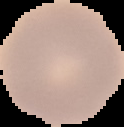

In [259]:
image = ['/home/rosmael/Documents/My essay phase/Models/cell_images/Parasitized/C39P4thinF_original_IMG_20150622_105102_cell_83.png',
        '/home/rosmael/Documents/My essay phase/Models/cell_images/Parasitized/C39P4thinF_original_IMG_20150622_105554_cell_14.png',
        '/home/rosmael/Documents/My essay phase/Models/cell_images/Parasitized/C39P4thinF_original_IMG_20150622_110435_cell_104.png',
        '/home/rosmael/Documents/My essay phase/Models/cell_images/Parasitized/C39P4thinF_original_IMG_20150622_110900_cell_6.png',
        '/home/rosmael/Documents/My essay phase/Models/cell_images/Uninfected/C1_thinF_IMG_20150604_104722_cell_211.png',
        "/home/rosmael/Documents/My essay phase/Models/cell_images/Uninfected/C2NThinF_IMG_20150604_114751_cell_142.png",
        "/home/rosmael/Documents/My essay phase/Models/cell_images/Uninfected/C2NThinF_IMG_20150604_114751_cell_106.png"]




img_path = image[6]
display(Image(img_path))
img_size = (224, 224)

In [251]:
# Defferent model are the following
# modelvgg16       = load_model('last_vgg_model.h5')
# modelDenseNet121 = load_model("malaria_predict_with_densenet121.h5")
# model_proposed   = load_model("malaria_predict_proposed_model.h5")





Vgg16model    = modelvgg16 
Densenetmodel = modelDenseNet121
proposedCNN   = model_proposed
print('Initialization of the models: Done ----100%')

Initialization of the models: Done ----100%


In [252]:
# Change the model to choice the one you want to use, and the lass Conv2D layer name

# change these element according to what we are using

#modelist = [Vgg16model, Densenetmodel, proposedCNN]
#layerlist = ['block5_conv3','conv5_block16_concat', 'conv2d_4']

model = Vgg16model
last_conv_layer_name = "block5_conv3"
print('Change of the last layer: Done ------100%')

Change of the last layer: Done ------100%


In [253]:
def get_img_array(img_path, size):
    """Preprocessing of the image and resize"""
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

In [254]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """First, we create a model that maps the input image to the activations
       of the last conv layer as well as the output predictions"""
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [255]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


1/1 [==============================] - 0s 262ms/step
[[1.4991394e-24]]


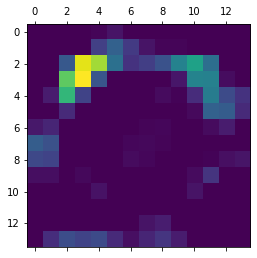

In [262]:
# Prepare image
img_array = get_img_array(img_path, size=img_size)

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print(preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

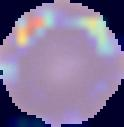

In [263]:
save_and_display_gradcam(img_path, heatmap)

# Obtained results using VGG16 and Model

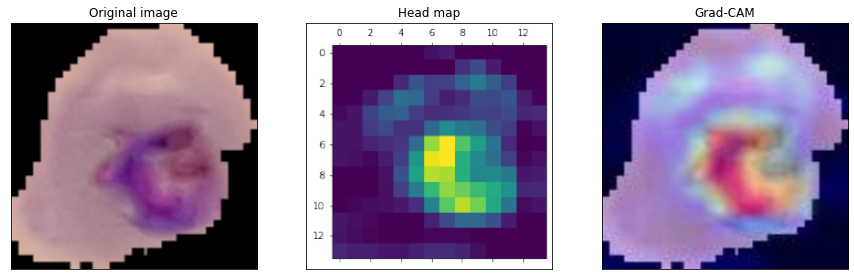

In [217]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

# Load the three images
img1 = plt.imread('/home/rosmael/Documents/My essay phase/Grad CAM recorded Image/image1vgg.png')
img2 = plt.imread('/home/rosmael/Documents/My essay phase/Grad CAM recorded Image/image2vgg.png')
img3 = plt.imread('/home/rosmael/Documents/My essay phase/Grad CAM recorded Image/image3vgg.jpeg')


img1_resized = resize(img1, (224, 224))
img2_resized = resize(img2, (224, 224))
img3_resized = resize(img3, (224, 224))
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 3 , 1)
plt.imshow(img1_resized)
plt.title('Original image')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 3 , 2)
plt.imshow(img2_resized)
plt.title('Head map')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 3 , 3)
plt.imshow(img3_resized)
plt.title('Grad-CAM')
plt.xticks([]) , plt.yticks([])

plt.show()

# Ontained result using DenseNet121 as Model

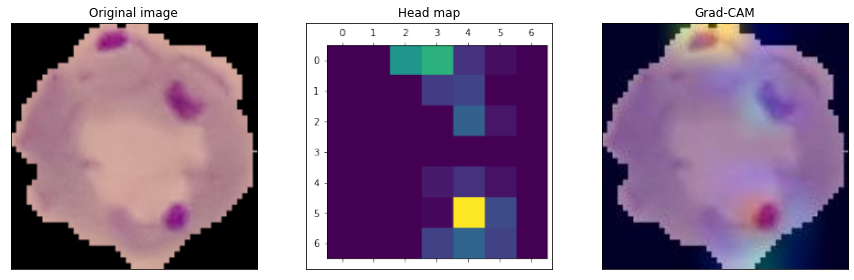

In [230]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

# Load the three images
img1 = plt.imread('/home/rosmael/Documents/My essay phase/Grad CAM recorded Image/image1dense.png')
img2 = plt.imread('/home/rosmael/Documents/My essay phase/Grad CAM recorded Image/image2dense.png')
img3 = plt.imread('/home/rosmael/Documents/My essay phase/Grad CAM recorded Image/image3dense.jpeg')


img1_resized = resize(img1, (224, 224))
img2_resized = resize(img2, (224, 224))
img3_resized = resize(img3, (224, 224))
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 3 , 1)
plt.imshow(img1_resized)
plt.title('Original image')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 3 , 2)
plt.imshow(img2_resized)
plt.title('Head map')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 3 , 3)
plt.imshow(img3_resized)
plt.title('Grad-CAM')
plt.xticks([]) , plt.yticks([])

plt.show()

# Obtained result using the proposed CNN as Model

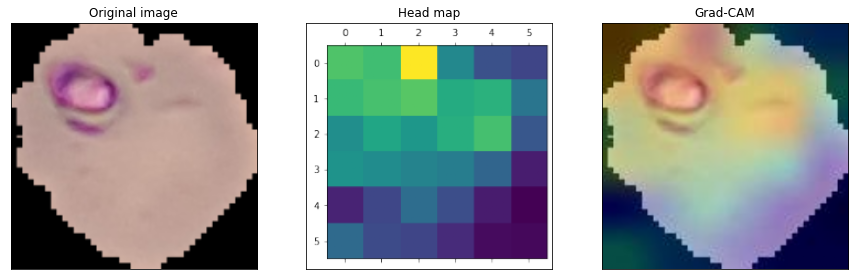

In [240]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

# Load the three images
img1 = plt.imread('/home/rosmael/Documents/My essay phase/Grad CAM recorded Image/image1proposed.png')
img2 = plt.imread('/home/rosmael/Documents/My essay phase/Grad CAM recorded Image/image2proposed.png')
img3 = plt.imread('/home/rosmael/Documents/My essay phase/Grad CAM recorded Image/image3proposed.jpeg')


img1_resized = resize(img1, (224, 224))
img2_resized = resize(img2, (224, 224))
img3_resized = resize(img3, (224, 224))
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 3 , 1)
plt.imshow(img1_resized)
plt.title('Original image')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 3 , 2)
plt.imshow(img2_resized)
plt.title('Head map')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 3 , 3)
plt.imshow(img3_resized)
plt.title('Grad-CAM')
plt.xticks([]) , plt.yticks([])

plt.show()

In [ ]:
# dispay the concern image and predict the image

# infected i = [33,38,49, 234, 410 , 157, 506]
# Uninfected i = [1, 42, 45,50, 230, 530]

i = 536

img = Test_x[i]
plt.imshow(img)
input_img = np.expand_dims(img, axis = 0)
print("The prediction for this image is: ", model.predict(input_img))
print("The actual label for this image is: ",Test_y[i]) 